### ControlNet+Canny Edge：实现利用边缘检测进行Diffusion

In [1]:
import os
os.environ['http_proxy'] = 'http://192.168.31.29:8603'
os.environ['https_proxy'] = 'http://192.168.31.29:8603'
os.environ['all_proxy'] = 'socks5://192.168.31.29:8603'

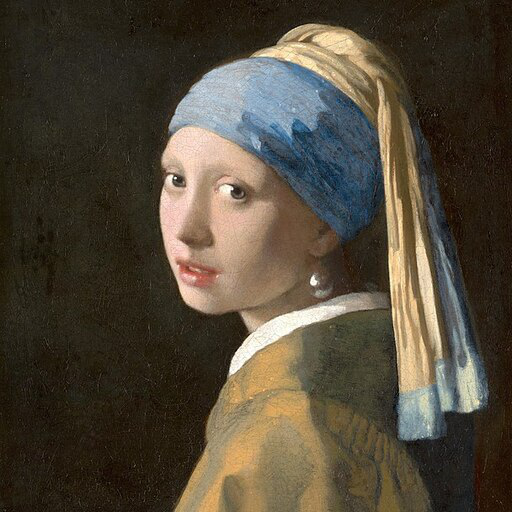

In [3]:
# 导入依赖
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

image = load_image(
    'input_image_vermeer.png'
)
image

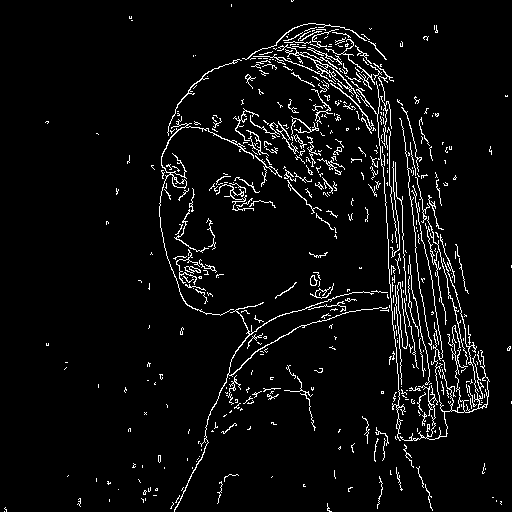

In [4]:
# 利用OpenCV的CannyEdge检测检测金发少女的边缘
import cv2
from PIL import Image
import numpy as np

image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:,:,None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
canny_image

In [5]:
# 接下来，交给ControlNet进行处理
from diffusers import StableDiffusionControlNetPipeline,ControlNetModel
import torch

controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny",
    torchdtype=torch.float16
).to("cuda")

In [6]:
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    torchdtype=torch.float16
).to("cuda")

Keyword arguments {'torchdtype': torch.float16} are not expected by StableDiffusionControlNetPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [7]:
# 添加UniPCMultistep调度器
from diffusers import UniPCMultistepScheduler
pipe.scheduler = UniPCMultistepScheduler.from_config(
    pipe.scheduler.config
)

In [8]:
# 定义生成函数
def image_grid(imgs,rows,cols):
    assert len(imgs) == rows*cols

    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w,rows*h))
    grid_w,grid_h = grid.size

    for i,img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [9]:
# 定义生成提示词
prompt = ", best quality,extremely detailed"

In [10]:
prompt = [t + prompt for t in ['Sandra Oh','Kim Kardashian','rihanna','Taylor Swift']]
generator = [torch.Generator(device='cuda').manual_seed(2) for i in range(len(prompt))]

In [11]:
output = pipe(
    prompt,
    canny_image,
    negative_prompt=['monochrome,lowres,bad anatomy,worst quality,low quality'] * len(prompt),
    generator=generator,
    num_inference_steps=20
)

  0%|          | 0/20 [00:00<?, ?it/s]

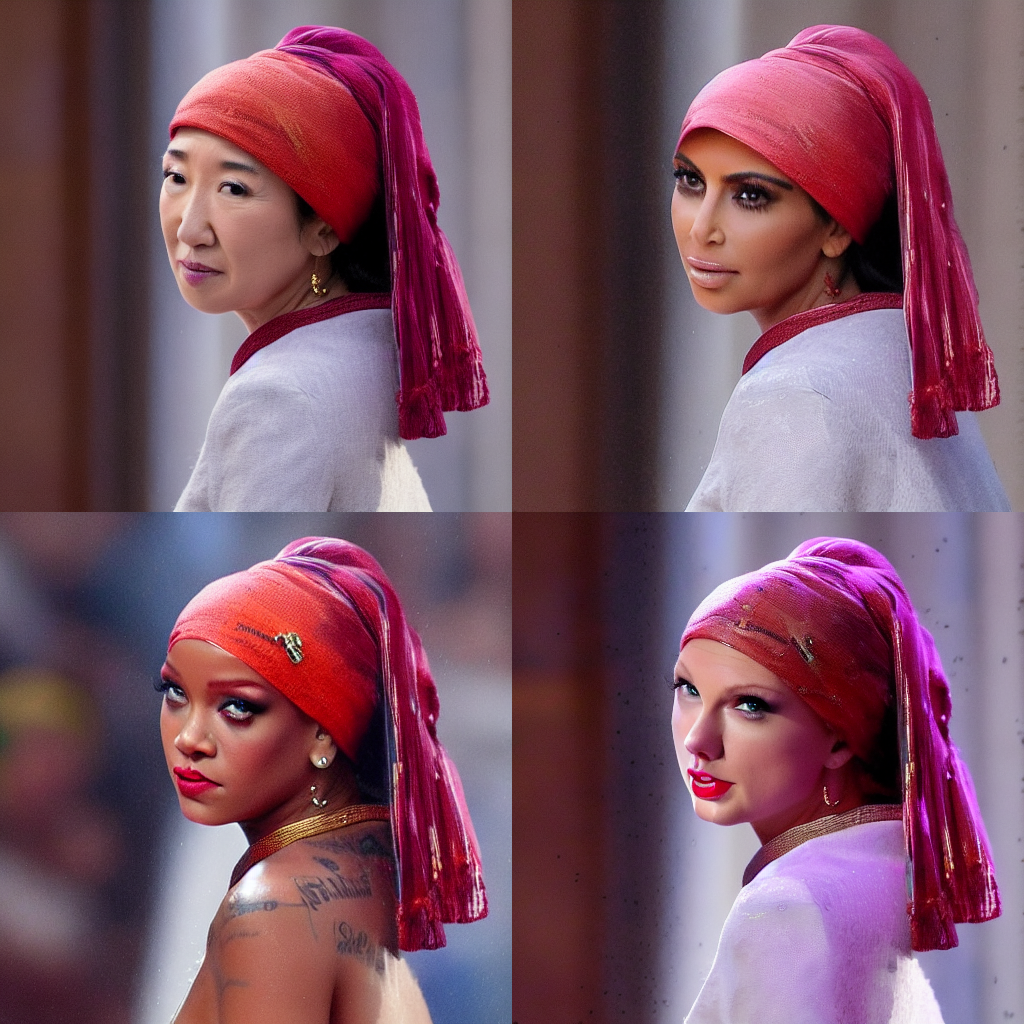

In [12]:
image_grid(output.images,2,2)

### 利用Control Net实现姿态检测

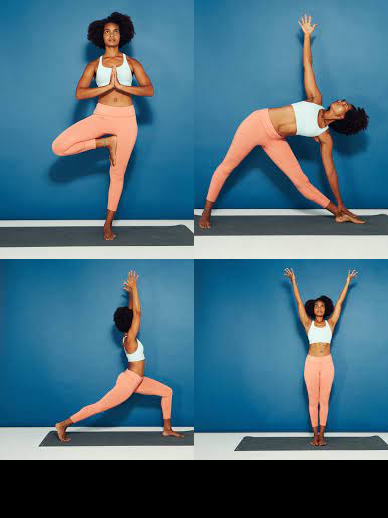

In [13]:
urls = [
    "yoga1.jpeg",
    "yoga2.jpeg",
    "yoga3.jpeg",
    "yoga4.jpeg",
]
imgs = [
    load_image(url) for url in urls
]
image_grid(imgs,2,2)

/root/anaconda3/envs/hugging/lib/python3.11/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


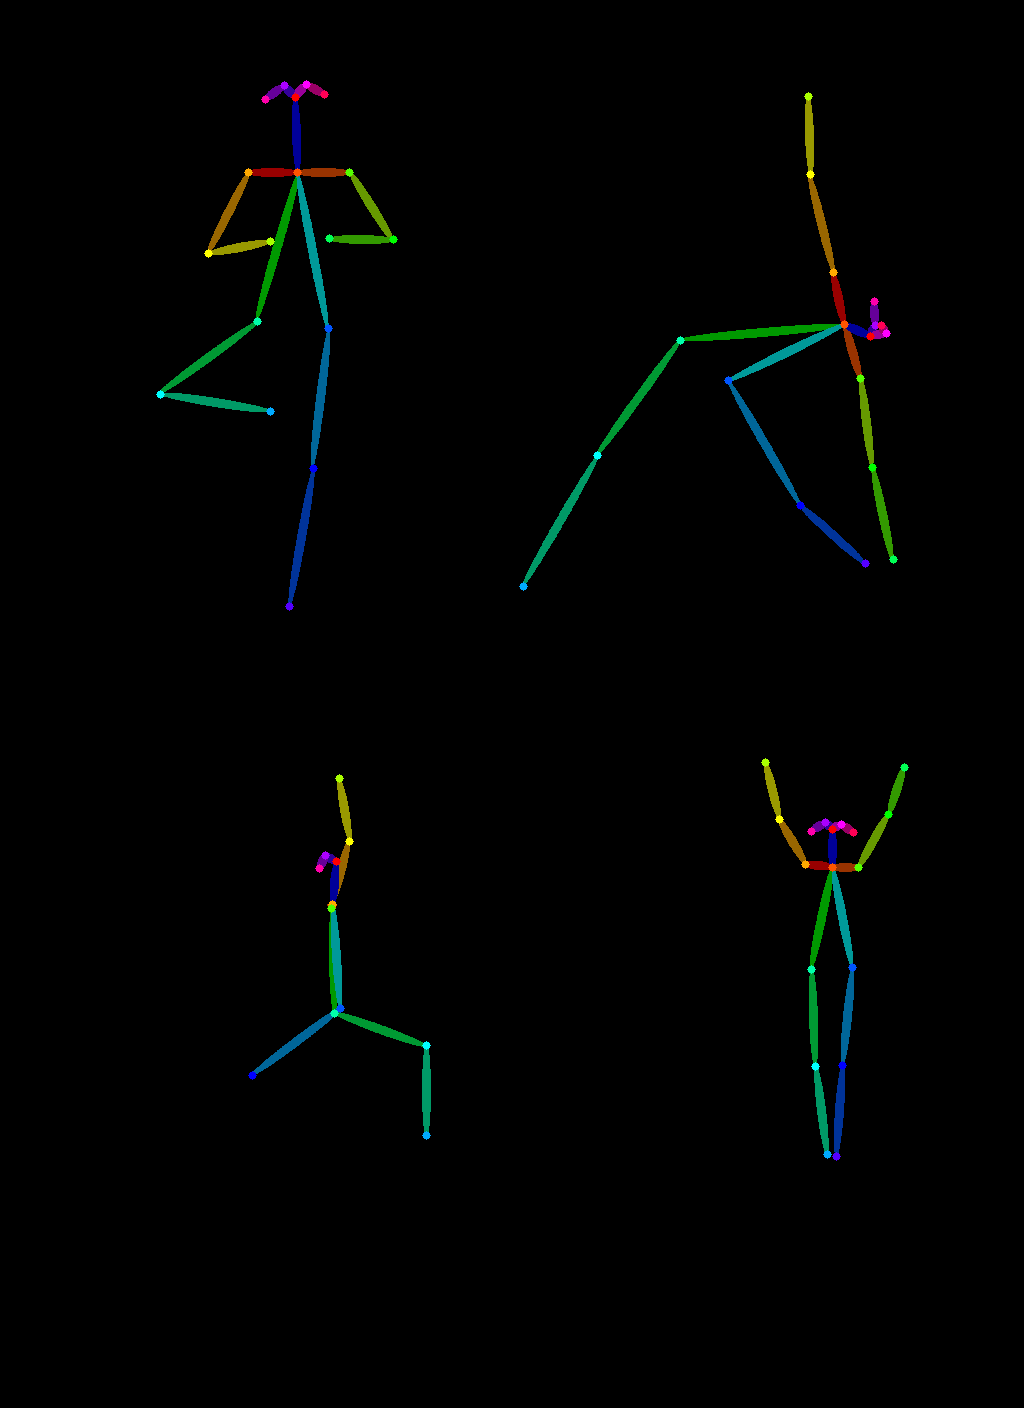

In [14]:
from controlnet_aux import OpenposeDetector
model = OpenposeDetector.from_pretrained(
    "lllyasviel/ControlNet")
poses = [model(img) for img in imgs]
image_grid(poses,2,2)